In [13]:
import torch
import time
from transformers import *
import numpy as np
import os, json

from collections import defaultdict
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, OPTICS
from sklearn import cluster, mixture
# t-sne
from sklearn import manifold
import sklearn
from sklearn.metrics import confusion_matrix
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import random

from sklearn.metrics import accuracy_score, precision_recall_fscore_support


random.seed(21)
np.random.seed(21)


In [14]:
base_path_new = "../../data"

file_paths_new = {
                'NQ': os.path.join(base_path_new, 'nq/train.jsonl'),
                'RACE': os.path.join(base_path_new, 'RACE/train.jsonl'),
                # 'SQuAD': os.path.join(base_path_new, 'squad/train.jsonl'),
                'SciQ':  os.path.join(base_path_new, 'SciQ/train.jsonl'),
            }
race_ds = [' '.join(json.loads(_)['text']).lower() for _ in open(file_paths_new['RACE'])]
sciq_ds = [' '.join(json.loads(_)['text']).lower() for _ in open(file_paths_new['SciQ'])]
dnq_ds = [json.loads(_) for _ in open(file_paths_new['NQ'])]
nq_ds = open(file_paths_new['NQ']).readlines()
print(len(nq_ds), len(sciq_ds), len(race_ds))


89453 11679 18613


In [15]:
drace_ds = [json.loads(_) for _ in open(file_paths_new['RACE'])]
dsciq_ds = [json.loads(_) for _ in open(file_paths_new['SciQ'])]


In [16]:
nq_race = torch.load("results_NQ-RACE.pt")

In [17]:
nq_race.keys()

dict_keys(['avg', 'cls', 'all', 'idx_for_clustering', 'num_samples_for_clustering'])

In [6]:
nq_race['all']['kmeans'].keys()

dict_keys(['centers', 'cluster_metrics', 'metrics', 'distances', 'corpus_idx', 'cluster_label_map'])

In [7]:
print(nq_race['all']['kmeans']['corpus_idx'])

{'NQ': 0, 'RACE': 89453}


In [8]:
nq_race['all']['kmeans']['cluster_label_map']

{0: 'NQ', 1: 'RACE'}

In [18]:
label_id_map = { v:k for k, v in nq_race['avg']['kmeans']['cluster_label_map'].items() }

In [19]:
race_label_id = label_id_map['RACE']
nq_label_id = label_id_map['NQ']
print(label_id_map, race_label_id, nq_label_id)

{'RACE': 0, 'NQ': 1} 0 1


In [25]:
# method_used = 'all'
method_used = 'avg'

In [26]:
nq_nq_kmeans_dis = nq_race[method_used]['kmeans']['distances'][:89453, nq_label_id]
nq_race_kmeans_dis = nq_race[method_used]['kmeans']['distances'][:89453, race_label_id]


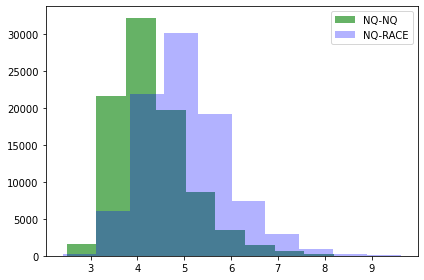

In [28]:
plt.hist(nq_nq_kmeans_dis, alpha=0.6, label='NQ-NQ', color='g')
plt.hist(nq_race_kmeans_dis, alpha=0.3, label='NQ-RACE', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("NQ-RACE-Distance-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [81]:
print(dnq_ds[np.argsort(nq_race_kmeans_dis)[0]]['src'])

[CLS] To expand the number of women smokers Hill decided to hire Edward Bernays, who today is known as the father of public relations, to help him recruit women smokers. Bernays decided to attempt to eliminate the social taboo against women smoking in public. He gained advice from psychoanalyst A. A. Brill, who stated that it was normal for women to smoke because of oral fixation and said, ` ` Today the emancipation of women has suppressed many of their feminine desires. More women now do the same work as men do. Many women bear no children ; those who do bear have fewer children. Feminine traits are masked. Cigarettes, which are equated with men, become torches of freedom.'' In 1929 Bernays decided to pay women to smoke their ` ` torches of freedom'' as they walked in the Easter Sunday Parade in New York. This was a shock because until that time, women were only permitted to smoke in certain places such as in the privacy of their own homes. He was very careful when picking women to ma

In [27]:
race_race_kmeans_dis = nq_race[method_used]['kmeans']['distances'][89453:, race_label_id]
race_nq_kmeans_dis = nq_race[method_used]['kmeans']['distances'][89453:, nq_label_id]

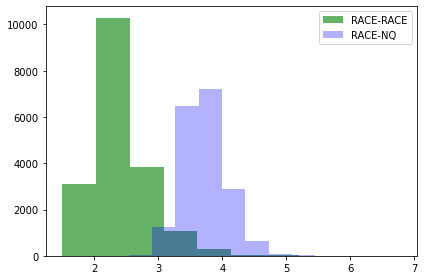

In [83]:
plt.hist(race_race_kmeans_dis, alpha=0.6, label='RACE-RACE', color='g')
plt.hist(race_nq_kmeans_dis , alpha=0.3, label='RACE-NQ', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("RACE-NQ-Distance-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [29]:
nq_race_center_cosine_distance = nq_race[method_used]['gmm']['other_center_cosine_distance'][:89453]
nq_race_center_l2_distance = nq_race[method_used]['gmm']['other_center_l2_distance'][:89453]

In [30]:
nq_nq_center_cosine_distance = nq_race[method_used]['gmm']['nq_center_cosine_distance'][:89453]
nq_nq_center_l2_distance = nq_race[method_used]['gmm']['nq_center_l2_distance'][:89453]

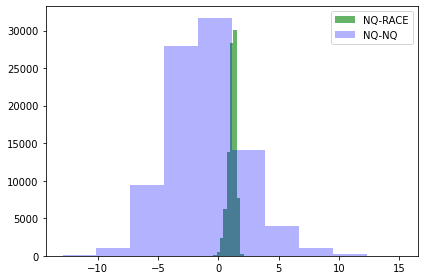

In [31]:
plt.hist(nq_race_center_cosine_distance, alpha=0.6, label='NQ-RACE', color='g')
plt.hist(nq_nq_center_cosine_distance , alpha=0.3, label='NQ-NQ', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("NQ-RACE-Center-Cosine-Distance-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

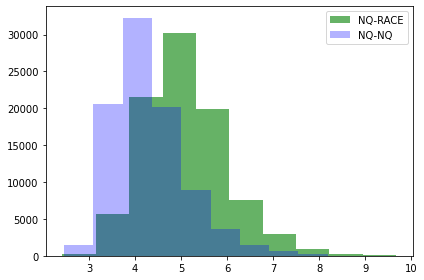

In [32]:
plt.hist(nq_race_center_l2_distance, alpha=0.6, label='NQ-RACE', color='g')
plt.hist(nq_nq_center_l2_distance , alpha=0.3, label='NQ-NQ', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("NQ-RACE-Center-l2-Distance-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [33]:
nq_nq_center_jensenshannon_distance = nq_race['avg']['gmm']['nq_center_jensenshannon_distance'][:89453]
nq_race_center_jensenshannon_distance = nq_race['avg']['gmm']['nq_center_jensenshannon_distance'][89453:]

In [34]:
nq_race['avg']['gmm'].keys()

dict_keys(['means', 'covar', 'cluster_metrics', 'metrics', 'proba', 'llscores', 'corpus_idx', 'cluster_label_map', 'cosine_metrics', 'nq_center_cosine_distance', 'other_center_cosine_distance', 'nq_center_l2_distance', 'other_center_l2_distance', 'nq_center_jensenshannon_distance', 'other_center_jensenshannon_distance'])

In [35]:
nq_race_l2_gmm_sorted_idx = np.argsort(nq_race_center_l2_distance)

In [37]:
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/race_gmm_l2_order/{e}.jsonl", "w")
    for j in range(0, e):
        line = nq_ds[nq_race_l2_gmm_sorted_idx[j]]
        item = json.loads(line)
        item['race_dis'] =  nq_race_center_l2_distance[nq_race_l2_gmm_sorted_idx[j]]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()


In [66]:
# sort NQ according to the distance to the target domain, far->near
nq_race_sorted_idx = np.argsort( nq_race_kmeans_dis )[::-1]

In [67]:
nq_race_kmeans_dis[nq_race_sorted_idx[-3:]]

array([2.41633021, 2.40410047, 2.2399957 ])

In [68]:
nq_race_sorted_ds = [nq_ds[_] for _ in nq_race_sorted_idx ]

In [70]:
f = open("../../data/nq/race_order/race_dis_ordered.jsonl", "w")
for i, line in enumerate(nq_race_sorted_ds):
    item = json.loads(line)
    item['race_dis'] = nq_race_kmeans_dis[nq_race_sorted_idx[i]]
    f.write(json.dumps(item))
    f.write('\n')
f.close()

In [69]:
print(len(nq_ds), len(nq_race_sorted_idx))

89453 89453


In [71]:
nq_race_ordered_idx = nq_race_sorted_idx[::-1]
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/race_order/{e}.jsonl", "w")
    for j in range(0, e):
        line = nq_ds[nq_race_ordered_idx[j]]
        item = json.loads(line)
        item['race_dis'] = nq_race_kmeans_dis[nq_race_ordered_idx[j]]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()

In [93]:
random_idx = np.arange(len(nq_ds))
np.random.shuffle(random_idx)
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/random/{e}.jsonl", "w")
    for j in range(0, e):
        line = nq_ds[random_idx[j]]
        item = json.loads(line)
        item['race_dis'] = nq_race_kmeans_dis[nq_race_ordered_idx[j]]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()

In [ ]:
# sample item for BERT Training.
nq_nq_center_l2_distance

In [72]:
race_nq_dis_diff = nq_nq_kmeans_dis - nq_race_kmeans_dis 

In [73]:
np.where(race_nq_dis_diff > 0)[0].shape

(7312,)

In [28]:
sorted_race_nq_dis_diff_idx = np.argsort(race_nq_dis_diff)[::-1]

In [31]:
nq_race_kmeans_dis[sorted_race_nq_dis_diff_idx[0]]

3.3595971319721594

In [29]:
dnq_ds[sorted_race_nq_dis_diff_idx[0]]['src']

'[CLS] It takes a village to raise a child is a proverb which means that it takes an entire community of different people interacting with children in order for children to experience and grow in a safe environment. The villages would look out for the children. This does not mean an entire village is responsible for raising your children. [SEP] it takes an entire community of different people interacting with children in order for children to experience and grow in a safe environment [SEP]'

In [65]:
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/race_nq_dis_diff/{e}.jsonl", "w")
    for j in range(0, e):
        line = nq_ds[sorted_race_nq_dis_diff_idx[j]]
        item = json.loads(line)
        item['race_dis'] = nq_race_kmeans_dis[nq_race_ordered_idx[j]]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()

In [32]:
nq_mis_race_idx = np.where(race_nq_dis_diff > 0)[0]
sorted_nq_mis_race_idx = np.argsort( nq_race_kmeans_dis[nq_mis_race_idx] )


In [33]:
json.loads(nq_ds[nq_mis_race_idx[sorted_nq_mis_race_idx[0]]])['src']

"[CLS] To expand the number of women smokers Hill decided to hire Edward Bernays, who today is known as the father of public relations, to help him recruit women smokers. Bernays decided to attempt to eliminate the social taboo against women smoking in public. He gained advice from psychoanalyst A. A. Brill, who stated that it was normal for women to smoke because of oral fixation and said, ` ` Today the emancipation of women has suppressed many of their feminine desires. More women now do the same work as men do. Many women bear no children ; those who do bear have fewer children. Feminine traits are masked. Cigarettes, which are equated with men, become torches of freedom.'' In 1929 Bernays decided to pay women to smoke their ` ` torches of freedom'' as they walked in the Easter Sunday Parade in New York. This was a shock because until that time, women were only permitted to smoke in certain places such as in the privacy of their own homes. He was very careful when picking women to m

In [32]:
for i in range(0, 10000, 1000):
    e = min(i+1000, len(sorted_nq_mis_race_idx))
    f = open(f"../../data/nq/race_mis_nq/{e}.jsonl", "w")
    for j in range(0, e):
        idx = nq_mis_race_idx[sorted_nq_mis_race_idx[j]]
        line = nq_ds[idx]
        item = json.loads(line)
        item['race_dis'] = nq_race_kmeans_dis[idx]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()

In [94]:
gmm_label_id_map = { v:k for k, v in nq_race[method_used]['gmm']['cluster_label_map'].items() }
race_label_id = label_id_map['RACE']
nq_label_id = label_id_map['NQ']
print(label_id_map, race_label_id, nq_label_id)

{'RACE': 0, 'NQ': 1} 0 1


In [95]:
race_race_gmm_prob = nq_race[method_used]['gmm']['proba'][89453:, race_label_id]
race_nq_gmm_prob = nq_race[method_used]['gmm']['proba'][89453:, nq_label_id]

In [96]:
nq_race_gmm_prob = nq_race[method_used]['gmm']['proba'][:89453, race_label_id]
nq_nq_gmm_prob = nq_race[method_used]['gmm']['proba'][:89453, nq_label_id]

In [49]:
np.sort(nq_race_gmm_prob)[-2000]

1.0

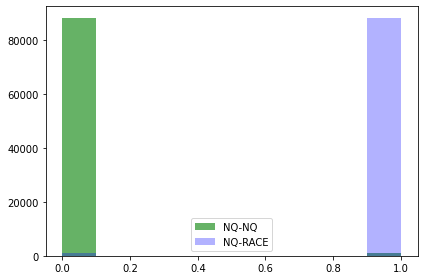

In [50]:
plt.hist(nq_nq_gmm_prob, alpha=0.6, label='NQ-NQ', color='g')
plt.hist(nq_race_gmm_prob, alpha=0.3, label='NQ-RACE', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("NQ-RACE-GMM-Proba-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [44]:
np.where(nq_race_gmm_prob > 0.9)[0].shape

(88054,)

In [41]:
gmm_nq_mis_race_idx = np.where(nq_race_gmm_prob > 0.5)[0]
gmm_sorted_nq_mis_race_idx = np.argsort( nq_race_gmm_prob[gmm_nq_mis_race_idx] )[::-1]

In [42]:
print(len(gmm_nq_mis_race_idx), nq_race_gmm_prob[gmm_nq_mis_race_idx[gmm_sorted_nq_mis_race_idx[-1]]])

88306 0.5031166212430672


In [39]:
for i in range(0, 10000, 1000):
    e = min(i+1000, len(gmm_sorted_nq_mis_race_idx))
    f = open(f"../../data/nq/gmm_race_mis_nq/{e}.jsonl", "w")
    for j in range(0, e):
        idx = gmm_nq_mis_race_idx[gmm_sorted_nq_mis_race_idx[j]]
        line = nq_ds[idx]
        item = json.loads(line)
        item['gmm_prob'] = nq_race_gmm_prob[idx]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()

In [99]:
gmm_centers = nq_race[method_used]['gmm']['means']

In [100]:
gmm_centers.shape

(2, 100)

In [ ]:
nq_gmm_center = gmm_centers[nq_label_id, :]
race_gmm_center = gmm_centers[race_label_id, :]

In [84]:
nq_sciq = torch.load("results_NQ-SciQ.pt")

In [85]:
label_id_map = { v:k for k, v in nq_sciq['all']['kmeans']['cluster_label_map'].items() }

In [86]:
print( nq_sciq['all']['kmeans']['cluster_label_map'], label_id_map)

{0: 'SciQ', 1: 'NQ'} {'SciQ': 0, 'NQ': 1}


In [87]:
nq_sciq['all']['kmeans']['corpus_idx']

{'NQ': 0, 'SciQ': 89453}

In [88]:
sciq_label_id = label_id_map['SciQ']
nq_label_id = label_id_map['NQ']
nq_sciq_dis = nq_sciq['all']['kmeans']['distances'][:89453, sciq_label_id]
nq_nq_dis = nq_sciq['all']['kmeans']['distances'][:89453, nq_label_id]

sciq_sciq_dis = nq_sciq['all']['kmeans']['distances'][89453:, sciq_label_id]
sciq_nq_dis = nq_sciq['all']['kmeans']['distances'][89453:, nq_label_id]

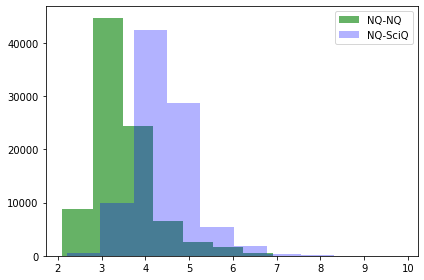

In [89]:
plt.hist(nq_nq_dis, alpha=0.6, label='NQ-NQ', color='g')
plt.hist(nq_sciq_dis, alpha=0.3, label='NQ-SciQ', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("NQ-SciQ-Distance-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

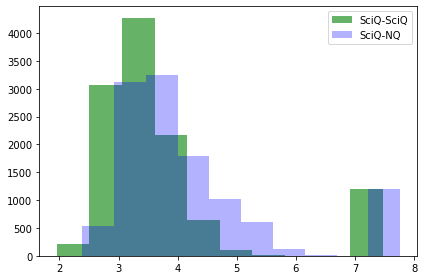

In [90]:
plt.hist(sciq_sciq_dis, alpha=0.6, label='SciQ-SciQ', color='g')
plt.hist(sciq_nq_dis , alpha=0.3, label='SciQ-NQ', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("SciQ-NQ-Distance-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [91]:
np.sort(nq_sciq_dis)[:3]

array([2.20199175, 2.20199175, 2.22113429])

In [92]:
# sort NQ according to the distance to the target domain, far->near
nq_sciq_sorted_idx = np.argsort( nq_sciq_dis )[::-1]

In [93]:
nq_sciq_dis[nq_sciq_sorted_idx[-3:]]

array([2.22113429, 2.20199175, 2.20199175])

In [141]:
nq_sciq_sorted_ds = [nq_ds[_] for _ in nq_sciq_sorted_idx ]

In [142]:
f = open("../../data/nq/sciq_order/sciq_dis_ordered.jsonl", "w")
for i, line in enumerate(nq_sciq_sorted_ds):
    item = json.loads(line)
    item['race_dis'] = nq_sciq_dis[ nq_sciq_sorted_idx[i] ]
    f.write(json.dumps(item))
    f.write('\n')
f.close()

In [143]:
nq_sciq_ordered_idx = nq_sciq_sorted_idx[::-1]
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/sciq_order/{e}.jsonl", "w")
    for j in range(i, e):
        line = nq_ds[nq_sciq_ordered_idx[j]]
        item = json.loads(line)
        item['sciq_dis'] = nq_sciq_dis[nq_sciq_ordered_idx[j]]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()


In [94]:
nq_sciq_center_cosine_distance = nq_sciq[method_used]['gmm']['other_center_cosine_distance'][:89453]
nq_sciq_center_l2_distance = nq_sciq[method_used]['gmm']['other_center_l2_distance'][:89453]
nq_nq_center_cosine_distance = nq_sciq[method_used]['gmm']['nq_center_cosine_distance'][:89453]
nq_nq_center_l2_distance = nq_sciq[method_used]['gmm']['nq_center_l2_distance'][:89453]

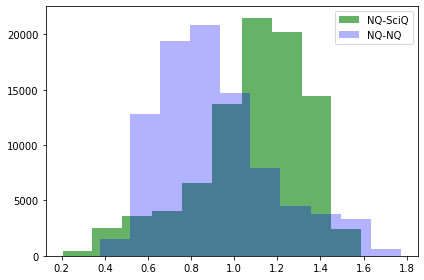

In [95]:
plt.hist(nq_sciq_center_cosine_distance, alpha=0.6, label='NQ-SciQ', color='g')
plt.hist(nq_nq_center_cosine_distance , alpha=0.3, label='NQ-NQ', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("NQ-SciQ-Center-Cosine-Distance-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

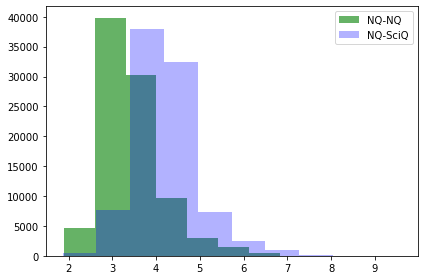

In [247]:
plt.hist(nq_nq_center_l2_distance , alpha=0.6, label='NQ-NQ', color='g')
plt.hist(nq_sciq_center_l2_distance, alpha=0.3, label='NQ-SciQ', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("NQ-SciQ-Center-l2-Distance-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [146]:
nq_sciq_l2_gmm_sorted_idx = np.argsort(nq_sciq_center_l2_distance)

In [147]:
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/sciq_gmm_l2_order/{e}.jsonl", "w")
    for j in range(0, e):
        line = nq_ds[nq_sciq_l2_gmm_sorted_idx[j]]
        item = json.loads(line)
        item['sciq_dis'] =  nq_sciq_center_l2_distance[nq_sciq_l2_gmm_sorted_idx[j]]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()


In [53]:
dnq_ds[nq_sciq_sorted_idx[-1]]['src']

'[CLS] The lysosomes also act as the waste disposal system of the cell by digesting unwanted materials in the cytoplasm, both from outside the cell and obsolete components inside the cell. Material from outside the cell is taken - up through endocytosis, while material from the inside of the cell is digested through autophagy. Their sizes can be very different - - the biggest ones can be more than 10 times bigger than the smallest ones. They were discovered and named by Belgian biologist Christian de Duve, who eventually received the Nobel Prize in Physiology or Medicine in 1974. [SEP] endocytosis [SEP]'

In [54]:
dnq_ds[ nq_race_sorted_idx[-1] ]['src']

"[CLS] A man named Bailey intends to take his family from Georgia to Florida for a summer vacation, but his mother, ( referred to as ` ` the grandmother'' in the story ) wants him to drive to East Tennessee, where the grandmother has friends ( ` ` connections'' ). She argues that his children, John Wesley and June Star, have never been to East Tennessee, and she shows him a news article in the Atlanta Journal Constitution about an escaped murderer who calls himself The Misfit last seen in Florida. The next day, the grandmother wakes up early to hide her cat, Pitty Sing, in a basket on the floor in the back of the car. She is worried that the cat would die while they were gone. Bailey finds her sitting in the car, dressed in her best clothes and an ostentatious hat ; she says that if she should die in an accident along the road, she wants people to see her corpse and know she was refined and ` ` a lady.'' The Grandmother talks continuously during the trip, trying to engage her two rude 

In [55]:
' '.join(dnq_ds[ nq_race_sorted_idx[-1] ]['tgt'])

'who goes on the family road trip to florida a good man is hard to find ?'

In [56]:
' '.join(dnq_ds[ nq_race_sorted_idx[-50] ]['text'])

"In his blog , he writes that he is the Director of WHO DID THIS . The company he works for , Altrucell , advertises itself as the world 's largest producer of the felt covers of tennis balls ; however , Future Ted implies that the company 's main profits come from other , less innocent sources , such as logging , oil drilling , small arms , tobacco farming and missile construction . Barney states in ` ` Cupcake '' that , as a lawyer for Altrucell , Marshall would make more money in three months than he and Lily make in a year because his company has so many lawsuits against it . In the season 3 episode ` ` The Bracket , '' he says that he is good enough at lying to avoid perjury charges . As of Season 4 , his company is involved in a hostile takeover of Goliath National Bank ( GNB ) and consequently shifts him to the management team of the bank , but he remains a powerful     executive     and continues to use the same office he has had since it was first shown in Season 1 . Despite t

In [57]:
dnq_ds[ nq_race_sorted_idx[-50] ]['src']

"[CLS] In his blog, he writes that he is the Director of WHO DID THIS. The company he works for, Altrucell, advertises itself as the world's largest producer of the felt covers of tennis balls ; however, Future Ted implies that the company's main profits come from other, less innocent sources, such as logging, oil drilling, small arms, tobacco farming and missile construction. Barney states in ` ` Cupcake'' that, as a lawyer for Altrucell, Marshall would make more money in three months than he and Lily make in a year because his company has so many lawsuits against it. In the season 3 episode ` ` The Bracket,'' he says that he is good enough at lying to avoid perjury charges. As of Season 4, his company is involved in a hostile takeover of Goliath National Bank ( GNB ) and consequently shifts him to the management team of the bank, but he remains a powerful executive and continues to use the same office he has had since it was first shown in Season 1. Despite this, he has suggested the

In [58]:
' '.join(dnq_ds[ nq_race_sorted_idx[-50] ]['tgt'])

'what does barney work as in how i met your mother ?'

In [59]:
' '.join(dnq_ds[ nq_sciq_sorted_idx[-40] ]['text'])

"Cellular respiration is a set of metabolic reactions and processes that take place in the cells of organisms to convert     biochemical energy     from nutrients into adenosine triphosphate ( ATP ) , and then release waste products . The reactions involved in respiration are catabolic reactions , which break large molecules into smaller ones , releasing energy in the process , as weak so - called ` ` high - energy '' bonds are replaced by stronger bonds in the products . Respiration is one of the key ways a cell releases chemical energy to fuel cellular activity . Cellular respiration is considered an exothermic redox reaction which releases heat . The overall reaction occurs in a series of biochemical steps , most of which are redox reactions themselves . Although cellular respiration is technically a combustion reaction , it clearly does not resemble one when it occurs in a living cell because of the slow release of energy from the series of reactions ."

In [60]:
' '.join(dnq_ds[ nq_sciq_sorted_idx[-40] ]['tgt'])

'the purpose of cellular respiration is to enable cells to create and use what ?'

In [97]:
dnq_ds[ nq_sciq_sorted_idx[-1] ]['src']

'[CLS] The lysosomes also act as the waste disposal system of the cell by digesting unwanted materials in the cytoplasm, both from outside the cell and obsolete components inside the cell. Material from outside the cell is taken - up through endocytosis, while material from the inside of the cell is digested through autophagy. Their sizes can be very different - - the biggest ones can be more than 10 times bigger than the smallest ones. They were discovered and named by Belgian biologist Christian de Duve, who eventually received the Nobel Prize in Physiology or Medicine in 1974. [SEP] endocytosis [SEP]'

In [101]:
' '.join(dnq_ds[ nq_sciq_sorted_idx[-1] ]['tgt'])

'the process of lysosomes digesting materials is called ?'

In [100]:
dnq_ds[ nq_race_sorted_idx[-50] ]['src']

"[CLS] Anthony Hopkins as Odin : The ruler of Asgard, father of Thor, and adoptive father of Loki, based on the mythological deity of the same name. In an interview Hopkins stated he knew nothing of the comic. About the film he said, ` ` It's a superhero movie, but with a bit of Shakespeare thrown in''. Hopkins stated, ` ` I'm very interested in that relationship between fathers and sons'', and that, ` ` My father's relationship with me was cold. He was a hot - blood character but to me, cold. When I was young, he expressed his disappointment because I was bad in school and all of that. He didn't mean any harm, but I felt I could never meet up to his expectations.'' Hopkins expressed that he found a personal resonance in the Odin role, saying, ` ` He's a stern man. He's a man with purpose. I play the god who banishes his son from the kingdom of Asgard because he screwed up. He's a hot - headed, temperamental young man... probably a chip off of the old block but I decide he's not really

In [112]:
print(dnq_ds[ nq_race_sorted_idx[-8] ]['src'])
print(' '.join(dnq_ds[ nq_race_sorted_idx[-8] ]['tgt']))

[CLS] In 1977, the McDonald's restaurant owner clients who regularly met with Bernstein were looking for ways to create a better experience for families with kids. Bernstein reasoned that if kids could get a packaged meal all their own instead of just picking at their parent's food, everybody would be happier. He had often noticed his young son at the breakfast table poring over the various items on cereal boxes and thought, ` ` Why not do that for McDonald's? The package is the key!'' He then called in his creative team and had them mock up some paperboard boxes fashioned to resemble lunch pails with the McDonald's Golden Arches for handles. They called in nationally known children's illustrators and offered them the blank slate of filling the box's sides and tops with their own colorful ideas from art to jokes to games to comic strips to stories to fantasy : whatever they thought might appeal to kids, at least 8 items per box. Inside the box would be a burger, small fries, packet of 

In [109]:
drace_ds[ np.argsort(race_nq_kmeans_dis)[10] ]['src']

'[CLS] If you did, reread it! 7. The Story of Edgar Sawtelle By David Wroblewski 576 pages ; Harper Collins A kind of Hamlet on the prairie, this is the wrenching story of a mute boy and his dog. Oprah compares it to East of Eden and To Kill a Mickingbird. 8. The Pillars of the Earth By Ken Follett 973 pages ; Penguin About the challenges of building cathedrals in 12th - century England. This novel couldn\'t be more different in setting, time, and plot from the author\'s breakthrough success, Eye of the Needle. Oprah declares it simply " great ". 9. The Bluest Eye By Toni Morrison 224 pages ; Penguin How to choose among the great Morrison\'s novel? Start with this one about a girl who thinks she has to have blue eyes to be beautiful. Oprah considered it one of the best in a crowded Morrison field. 10. The Known World By Edward P. Jones 400 pages, Harper Collins When this book was published in 2003, it shocked everybody with its description of slave - owning blacks before the Civil War.

In [108]:
dsciq_ds[ np.argsort(sciq_nq_dis)[10] ]['src']

'[CLS] Figure 15. 2 All animals that derive energy from food are heterotrophs. The ( a ) black bear is an omnivore, eating both plants and animals. The ( b ) heartworm Dirofilaria immitis is a parasite that derives energy from its hosts. It spends its larval stage in mosquitos and its adult stage infesting the hearts of dogs and other mammals, as shown here. ( credit a : modification of work by USDA Forest Service ; credit b : modification of work by Clyde Robinson ). [SEP] heterotrophs [SEP]'

In [9]:
nq_race_class_dis = nq_race['all']['kmeans']['distances'][:89453, :]

In [18]:
nq_race_class_dis[np.argsort(nq_race_kmeans_dis)[7000]]

array([3.05665355, 3.0868892 ])

In [19]:
dis_diff = nq_race_class_dis[:, 1] - nq_race_class_dis[:, 0]

In [37]:
race_beeter_idx = np.where(dis_diff > 0)[0]

In [38]:
race_beeter_idx.shape

(7164,)

In [40]:
np.argmin(nq_race_kmeans_dis[race_beeter_idx])

5792

In [41]:
nq_race_class_dis[race_beeter_idx[5792]]

array([1.8997909 , 3.13308414])

In [28]:
dnq_ds[race_beeter_idx[1]]['src']

"[CLS] During play, a team consists of six players : a goaltender and five ` ` runners''. A runner is any non - goalkeeper position player, including forwards, transition players, and defenders. Runners usually specialize in one of these roles and substitute off the field when the ball moves from one end to the other. When the sport originated teams played with six runners. However, in 1953 the sixth runner, a position called rover, was eliminated. The goalkeeper can be replaced by another runner, often when a delayed penalty has been called on the other team or at the end of games by teams that are behind to help score goals. [SEP] six [SEP]"

In [31]:
np.sort(nq_race_kmeans_dis)[10000]

3.1840374384517673

In [42]:
dnq_ds[race_beeter_idx[5792]]['src']

"[CLS] To expand the number of women smokers Hill decided to hire Edward Bernays, who today is known as the father of public relations, to help him recruit women smokers. Bernays decided to attempt to eliminate the social taboo against women smoking in public. He gained advice from psychoanalyst A. A. Brill, who stated that it was normal for women to smoke because of oral fixation and said, ` ` Today the emancipation of women has suppressed many of their feminine desires. More women now do the same work as men do. Many women bear no children ; those who do bear have fewer children. Feminine traits are masked. Cigarettes, which are equated with men, become torches of freedom.'' In 1929 Bernays decided to pay women to smoke their ` ` torches of freedom'' as they walked in the Easter Sunday Parade in New York. This was a shock because until that time, women were only permitted to smoke in certain places such as in the privacy of their own homes. He was very careful when picking women to m

In [51]:
method='avg'

In [179]:
nq_race = torch.load("results_NQ-RACE.pt")

In [145]:
nq_nq_cosine_distance = nq_race['avg']['gmm']['nq_center_cosine_distance'][:89453]
nq_race_cosine_distance = nq_race['avg']['gmm']['other_center_cosine_distance'][:89453]

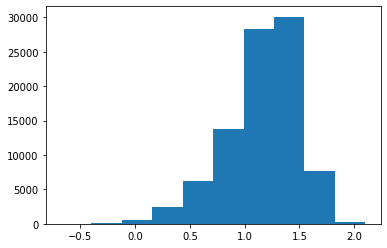

In [146]:
plt.hist(nq_race_cosine_distance)
plt.show()

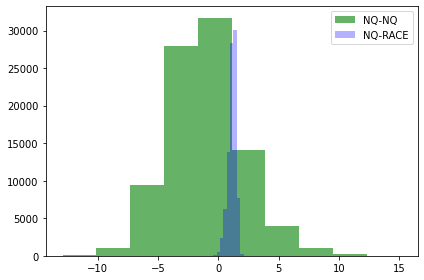

In [147]:
plt.hist(nq_nq_cosine_distance, alpha=0.6, label='NQ-NQ', color='g')
plt.hist(nq_race_cosine_distance , alpha=0.3, label='NQ-RACE', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("NQ-RACE-GMM-Center-Cosine-Distance-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [125]:
nq_race_cosine_idx = np.argsort(nq_race_cosine_distance)

In [126]:
nq_race_cosine_distance[nq_race_cosine_idx[-1]]

2.1201777729007674

In [ ]:
print(nq_ds[nq_race_cosine_idx[0]])

In [129]:
print(dnq_ds[nq_race_cosine_idx[0]]['src'], nq_race_cosine_distance[nq_race_cosine_idx[0]])

[CLS] In 1998, Linda M. Hooper, principal of Whitwell Middle School in Whitwell, Tennessee, asked Assistant Principal David Smith to find a voluntary after - school project to teach the children about tolerance. David Smith and Sandra Roberts started a Holocaust education program and held the first class in the fall of 1998. Soon the students were overwhelmed with the massive scale of the Holocaust and asked Mrs. Hooper if they could collect something to represent the lives that were exterminated during the Holocaust. Mrs. Hooper responded that they could if they could find something that related to the Holocaust or to World War II. Through Internet research, the students discovered that Johan Vaaler, a Norwegian, designed a loop of metal, and the Norwegians wore paperclips on their lapels during World War II as a silent protest against Nazi occupation. The students decided to collect 6, 000, 000 paper clips to represent the estimated 6, 000, 000 Jews killed between 1939 and 1945 under

In [130]:
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/race_gmm_cosine_order/{e}.jsonl", "w")
    for j in range(0, e):
        line = nq_ds[nq_race_cosine_idx[j]]
        item = json.loads(line)
        item['race_dis'] =  nq_race_cosine_distance[nq_race_cosine_idx[j]]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()


In [ ]:
print(dnq_ds[np.argsort(nq_race_kmeans_dis)[0]]['src'])

In [131]:
nq_race['avg']['kmeans'].keys()

dict_keys(['centers', 'cluster_metrics', 'metrics', 'distances', 'corpus_idx', 'cluster_label_map'])

In [151]:
nq_race['avg']['kmeans']['cluster_label_map']

{0: 'RACE', 1: 'NQ'}

In [148]:
nq_nq_kmeans_distance = nq_race['avg']['kmeans']['distances'][:89453]
nq_race_kmeans_distance = nq_race['avg']['kmeans']['distances'][:89453]

In [149]:
nq_nq_kmeans_distance[0]

array([4.22712766, 4.33233359])

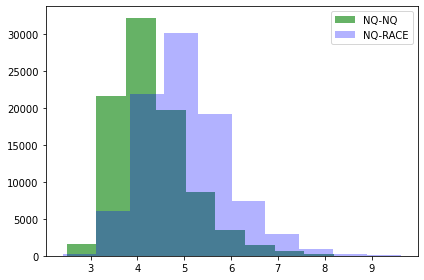

In [157]:
cluster_label_map = nq_race['avg']['kmeans']['cluster_label_map']
cluster_label_map = {v:k for k,v in cluster_label_map.items()}
plt.hist(nq_nq_kmeans_distance[:, cluster_label_map['NQ']], alpha=0.6, label='NQ-NQ', color='g')
plt.hist(nq_race_kmeans_distance[:, cluster_label_map['RACE']] , alpha=0.3, label='NQ-RACE', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("NQ-RACE-Kmeans-Center-L2-Distance-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [158]:
nq_race_kmeans_dis = nq_race_kmeans_distance[:, cluster_label_map['RACE']]
nq_race_kmeans_idx = np.argsort(nq_race_kmeans_dis)
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/race_kmeans_l2_order/{e}.jsonl", "w")
    for j in range(0, e):
        line = nq_ds[nq_race_kmeans_idx[j]]
        item = json.loads(line)
        item['race_dis'] =  nq_race_kmeans_dis[nq_race_kmeans_idx[j]]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()


In [162]:
print(dnq_ds[nq_race_kmeans_idx[1]]['src'], nq_race_kmeans_dis[nq_race_kmeans_idx[1]])

[CLS] A man named Bailey intends to take his family from Georgia to Florida for a summer vacation, but his mother, ( referred to as ` ` the grandmother'' in the story ) wants him to drive to East Tennessee, where the grandmother has friends ( ` ` connections'' ). She argues that his children, John Wesley and June Star, have never been to East Tennessee, and she shows him a news article in the Atlanta Journal Constitution about an escaped murderer who calls himself The Misfit last seen in Florida. The next day, the grandmother wakes up early to hide her cat, Pitty Sing, in a basket on the floor in the back of the car. She is worried that the cat would die while they were gone. Bailey finds her sitting in the car, dressed in her best clothes and an ostentatious hat ; she says that if she should die in an accident along the road, she wants people to see her corpse and know she was refined and ` ` a lady.'' The Grandmother talks continuously during the trip, trying to engage her two rude g

In [143]:
nq_race['all']['gmm']['metrics']

{'accuracy': 0.9635963207669387,
 'f1': 0.9000304940028461,
 'precision': 0.8538984521915233,
 'recall': 0.9514317949820018}

In [154]:
nq_nq_gmm_distance = nq_race['avg']['gmm']['nq_center_l2_distance'][:89453]
nq_race_gmm_distance = nq_race['avg']['gmm']['other_center_l2_distance'][:89453]

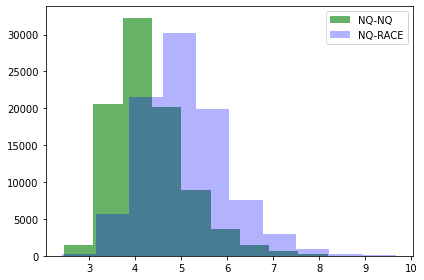

In [155]:
plt.hist(nq_nq_gmm_distance, alpha=0.6, label='NQ-NQ', color='g')
plt.hist(nq_race_gmm_distance, alpha=0.3, label='NQ-RACE', color='blue')
plt.legend()
plt.tight_layout()
plt.savefig("NQ-RACE-GMM-Center-L2-Distance-Distribution.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [243]:
nq_sciq = torch.load("results_NQ-SciQ.pt")

In [244]:
nq_nq_gmm_distance = nq_sciq['avg']['gmm']['nq_center_l2_distance'][:89453]
nq_sciq_gmm_distance = nq_sciq['avg']['gmm']['other_center_l2_distance'][:89453]

In [173]:
' '.join(dnq_ds[np.argsort(nq_sciq_gmm_distance)[0]]['text'])

'There are limits to electrophoretic techniques . Since passing current through a gel causes heating , gels may melt during electrophoresis . Electrophoresis is performed in buffer solutions     to reduce pH changes due to the electric field   , which is important because the charge of DNA and RNA depends on pH , but running for too long can exhaust the buffering capacity of the solution . There are also limitations in determining the molecular weight by SDS - PAGE , especially if you are trying to find the MW of an unknown protein . There are certain biological variables that are difficult or impossible to minimize and can affect the electrophoretic migration . Such factors include protein structure , post - translational modifications , and amino acid composition . For example , tropomyosin is an acidic protein that migrates abnormally on SDS - PAGE gels . This is because the acidic residues are repelled by the negatively charged SDS , leading to an inaccurate mass - to - charge rati

In [174]:
nq_sciq_kmeans_idx = np.argsort(nq_sciq_gmm_distance)
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/sciq_gmm_l2/{e}.jsonl", "w")
    for j in range(0, e):
        line = nq_ds[nq_sciq_kmeans_idx[j]]
        item = json.loads(line)
        item['race_dis'] =  nq_sciq_gmm_distance[nq_sciq_kmeans_idx[j]]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()


In [176]:
nq_sciq_kmeans_distance = nq_sciq['avg']['kmeans']['distances'][:89453]
cluster_label_map = nq_sciq['avg']['kmeans']['cluster_label_map']
cluster_label_map = {v:k for k,v in cluster_label_map.items()}

In [178]:
nq_sciq_kmeans_dis = nq_sciq_kmeans_distance[:, cluster_label_map['SciQ']]
nq_sciq_kmeans_idx = np.argsort(nq_sciq_kmeans_dis)
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/sciq_kmeans_l2/{e}.jsonl", "w")
    for j in range(0, e):
        line = nq_ds[nq_sciq_kmeans_idx[j]]
        item = json.loads(line)
        item['race_dis'] =  nq_sciq_kmeans_dis[nq_sciq_kmeans_idx[j]]
        f.write(json.dumps(item))
        f.write('\n')
    f.close()


In [177]:
cluster_label_map

{'NQ': 0, 'SciQ': 1}

In [4]:
def ans_type_recog(item):
    ent_types = {'': 0,
        'PERSON': 1,
        'ORG': 2,
        'CARDINAL': 3,
        'WORK_OF_ART': 4,
        'ORDINAL': 5,
        'DATE': 6,
        'NORP': 7,
        'GPE': 8,
        'LOC': 9,
        'FAC': 10,
        'LANGUAGE': 11,
        'PRODUCT': 12,
        'LAW': 13,
        'MONEY': 14,
        'TIME': 15,
        'QUANTITY': 16,
        'EVENT': 17,
        'PERCENT': 18
        }

    _time = ['DATE', 'TIME', 'EVENT']
    _location = ['NORP', 'GPE', 'LOC', 'FAC']
    _noun = ['LANGUAGE', 'PRODUCT', 'LAW', 'WORK_OF_ART' ]
    _number = ['MONEY', 'QUANTITY', 'CARDINAL', 'ORDINAL', 'PERCENT']
    _person = ['ORG', 'PERSON']
    
    ans_ner = item['ans_ner']
    ans_pos = item['ans_pos']

    ans_types = {}

    for pos, ner in zip(ans_pos, ans_ner):
        ans_type = 'noun' #'other'
        if pos in ['PUNCT', 'DET', 'PART', 'DEP', 'ADP']:
            continue
        if ner in _time:
            ans_type = 'time'
            
        elif ner in _location:
            ans_type = 'location'
        elif ner in _number:
            ans_type = 'numeric'
        elif ner in _person:
            ans_type = 'person'
        elif ner in _noun:
            ans_type = 'noun'
        elif pos in ['PROPN', 'NOUN', 'PART']:
            ans_type = 'noun'
        elif pos in ['VERB']:
            ans_type = 'verb'
        elif pos in ['ADJ']:
            ans_type = 'adjective'
        elif pos in ['ADV']:
            if 'verb' in ans_types:
                continue
            elif 'adjective' in ans_types:
                continue
        elif ner == '':
            if pos in ['NUM']:
                ans_type = 'numeric'
            elif pos in ['ADV']:
                ans_type = 'adjective'
            else:
                ans_type = 'noun'

        ans_types[ans_type] = ans_types.get(ans_type, 0) + 1
        
    ans_type = 'noun'
    types = list(ans_types.keys())
    if len(ans_pos) > 5 or ('noun' in ans_types and 'verb' in ans_types  ):
        ans_type = 'clause'
    elif len(types) == 1:
        ans_type = types[0]
    elif 'adjective' in ans_types and 'noun' in ans_types and 'verb' not in ans_types:
        ans_type = 'noun'
    elif 'time' in ans_types:
        ans_type = 'time'
    elif 'location' in ans_types:
        ans_type = 'location'
    elif 'numeric' in ans_types:
        ans_type = 'numeric'
    elif 'person' in ans_types:
        ans_type = 'person'
    elif 'noun' in ans_types:
        ans_type = 'noun'
    elif 'verb' in ans_types:
        ans_type = 'verb'
    return ans_type



In [5]:
NQ_Answer_Types = [ans_type_recog(_) for _ in dnq_ds ]
RACE_Answer_Types = [ans_type_recog(_) for _ in drace_ds ]
SCIQ_Answer_Types = [ans_type_recog(_) for _ in dsciq_ds ]

In [6]:
NQ_Answer_Types[7]

'location'

(array([20139., 26777., 14788.,     0.,  7257.,  4760.,     0., 14378.,
          716.,   638.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

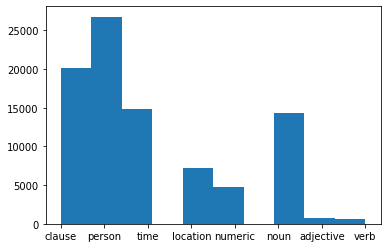

In [199]:
plt.hist(NQ_Answer_Types)

(array([ 1335., 11414.,   644.,     0.,   430.,  3388.,     0.,   805.,
          424.,   173.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

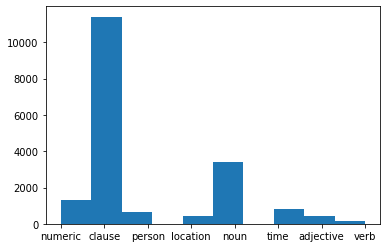

In [200]:
plt.hist(RACE_Answer_Types)

(array([ 377.,  510.,  779.,    0., 8927.,  677.,    0.,  289.,   57.,
          63.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

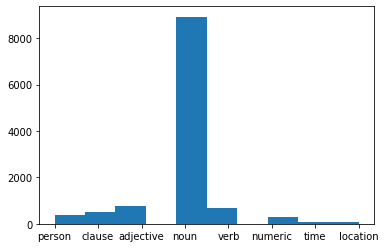

In [201]:
plt.hist(SCIQ_Answer_Types)

In [7]:
sciq_ans_distribution = {}
for ans in SCIQ_Answer_Types:
    sciq_ans_distribution[ans] = sciq_ans_distribution.get(ans, 0) + 1
race_ans_distribution = {}    
for ans in RACE_Answer_Types:
    race_ans_distribution[ans] = race_ans_distribution.get(ans, 0) + 1
for k, v in sciq_ans_distribution.items():
    sciq_ans_distribution[k] = v / float(len(SCIQ_Answer_Types))
for k, v in race_ans_distribution.items():
    race_ans_distribution[k] = v / float(len(RACE_Answer_Types))

In [8]:
sciq_ans_distribution

{'person': 0.03228016097268602,
 'clause': 0.043668122270742356,
 'adjective': 0.06670091617433,
 'noun': 0.7643633872763079,
 'verb': 0.05796729172018152,
 'numeric': 0.024745269286754003,
 'time': 0.004880554842024146,
 'location': 0.005394297456974056}

In [9]:
nq_sciq = torch.load("results_NQ-SciQ.pt")
nq_sciq_gmm_distance = nq_sciq['avg']['gmm']['other_center_l2_distance'][:89453]
nq_sciq_gmm_idx = np.argsort(nq_sciq_gmm_distance)

In [12]:
print(cluster_label_map)

{'NQ': 1}


In [11]:
nq_sciq_kmeans_distance = nq_sciq['avg']['kmeans']['distances'][:89453]
cluster_label_map = nq_sciq['avg']['kmeans']['cluster_label_map']
cluster_label_map = {v:k for k,v in cluster_label_map.items()}
nq_sciq_kmeans_dis = nq_sciq_kmeans_distance[:, cluster_label_map['SciQ']]
nq_sciq_kmeans_idx = np.argsort(nq_sciq_kmeans_dis)

KeyError: 'SciQ'

In [212]:
selected_idx = []
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/sciq_gmm_l2_ans-aware/{e}.jsonl", "w")
    for anstype, dist in sciq_ans_distribution.items():
        num = int(e * dist) + 1
        for idx in nq_sciq_gmm_idx:
            ans = ans_type_recog(dnq_ds[idx])
            if ans == anstype and num > 0:
                selected_idx.append(nq_ds[idx])
                num -= 1
            if num == 0:
                break
    for item in selected_idx[:e]:
        f.write(json.dumps(item))
        f.write('\n')
    f.close()


In [213]:
selected_idx = []
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/sciq_kmeans_l2_ans-aware/{e}.jsonl", "w")
    for anstype, dist in sciq_ans_distribution.items():
        num = int(e * dist) + 1
        for idx in nq_sciq_kmeans_idx:
            ans = ans_type_recog(dnq_ds[idx])
            if ans == anstype and num > 0:
                selected_idx.append(nq_ds[idx])
                num -= 1
            if num == 0:
                break
    for item in selected_idx[:e]:
        f.write(json.dumps(item))
        f.write('\n')
    f.close()


In [214]:
nq_race = torch.load("results_NQ-RACE.pt")
nq_race_gmm_distance = nq_race['avg']['gmm']['other_center_l2_distance'][:89453]
nq_race_gmm_idx = np.argsort(nq_race_gmm_distance)
nq_race_kmeans_distance = nq_race['avg']['kmeans']['distances'][:89453]
cluster_label_map = nq_race['avg']['kmeans']['cluster_label_map']
cluster_label_map = {v:k for k,v in cluster_label_map.items()}
nq_race_kmeans_dis = nq_race_kmeans_distance[:, cluster_label_map['RACE']]
nq_race_kmeans_idx = np.argsort(nq_race_kmeans_dis)

In [215]:
selected_idx = []
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/race_gmm_l2_ans-aware/{e}.jsonl", "w")
    for anstype, dist in race_ans_distribution.items():
        num = int(e * dist) + 1
        for idx in nq_race_gmm_idx:
            ans = ans_type_recog(dnq_ds[idx])
            if ans == anstype and num > 0:
                selected_idx.append(dnq_ds[idx])
                num -= 1
            if num == 0:
                break
    for item in selected_idx[:e]:
        f.write(json.dumps(item))
        f.write('\n')
    f.close()


In [216]:
selected_idx = []
for i in range(0, 10000, 1000):
    e = min(i+1000, len(nq_ds))
    f = open(f"../../data/nq/race_kmeans_l2_ans-aware/{e}.jsonl", "w")
    for anstype, dist in race_ans_distribution.items():
        num = int(e * dist) + 1
        for idx in nq_race_kmeans_idx:
            ans = ans_type_recog(dnq_ds[idx])
            if ans == anstype and num > 0:
                selected_idx.append(dnq_ds[idx])
                num -= 1
            if num == 0:
                break
    for item in selected_idx[:e]:
        f.write(json.dumps(item))
        f.write('\n')
    f.close()


In [218]:
ds = [json.loads(_) for _ in open("../../data/nq/race_kmeans_l2_ans-aware/1000.jsonl")]

In [227]:
ds[600]['src']

"[CLS] In Western culture, the finger or the middle finger ( as in giving someone the ( middle ) finger or the bird or flipping someone off ) is an obscene hand gesture. The gesture communicates moderate to extreme contempt, and is roughly equivalent in meaning to ` ` fuck off,'' ` ` fuck you,'' ` ` shove it up your ass,'' ` ` up yours,'' or ` ` go fuck yourself.'' It is performed by showing the back of a hand that has only the middle finger extended upwards, though in some locales, the thumb is extended. Extending the finger is considered a symbol of contempt in several cultures, especially in the West. Many cultures use similar gestures to display their disrespect, although others use it to express pointing without intentional disrespect toward other cultures. The gesture is usually used to express contempt but can also be used humorously or playfully. [SEP] communicates moderate to extreme contempt, and is roughly equivalent in meaning to ` ` fuck off,'' ` ` fuck you,'' ` ` shove it

In [220]:
ds2 = [json.loads(_) for _ in open("../../data/nq/race_gmm_l2_ans-aware/1000.jsonl")]

In [226]:
ds2[600]['src']

"[CLS] In the liner notes to the original release, Nat Hentoff calls the song ` ` a statement that maybe you can say to make yourself feel better... as if you were talking to yourself.'' It was written around the time that Suze Rotolo indefinitely prolonged her stay in Italy. The melody is based on the public domain traditional song ` ` Who's Gon na Buy Your Chickens When I'm Gone'' and was taught to Dylan by folksinger Paul Clayton, who had used it in his song ` ` Who's Gon na Buy You Ribbons When I'm Gone?'' [SEP] a statement that maybe you can say to make yourself feel better... as if you were talking to yourself [SEP]"

In [228]:
sciq_select = [json.loads(_) for _ in open("../../data/nq/sciq_gmm_l2_ans-aware/1000.jsonl")]
sciq_select_types = [ans_type_recog(_) for _ in sciq_select]

In [229]:
sciq_sel_dist = {}
for ans in sciq_select_types:
    sciq_sel_dist[ans] = sciq_sel_dist.get(ans, 0) + 1

In [230]:
sciq_sel_dist

{'person': 33,
 'clause': 44,
 'adjective': 67,
 'noun': 765,
 'verb': 58,
 'numeric': 25,
 'time': 5,
 'location': 3}

In [242]:
print(sciq_select[800]['ans_pos'])
print(sciq_select_types[800])

['DET', 'NOUN', 'CCONJ', 'ADJ', 'NOUN']
noun
